# Self-Attention Analysis


## Setup


In [1]:
# based on: https://github.com/naver-ai/cl-vs-mim/blob/main/self_attention_analysis.ipynb
import torch
import logging
import timm
import matplotlib.pyplot as plt
from functools import partial
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from collections import defaultdict
import matplotlib.pyplot as plt
from timm.utils import AverageMeter

import torch.nn.functional as F
from einops import rearrange, reduce, repeat
import torch.hub

logging.basicConfig(level=logging.INFO)

### Utils


In [2]:
def get_layer(model, layer_name: str):
    layers = layer_name.split(".")
    for layer in layers:
        if layer.isnumeric():
            model = model[int(layer)]
        elif hasattr(model, layer):
            model = getattr(model, layer)
        else:
            raise ValueError(f"Layer {layer} not found in {model}")
    return model


def clean_tensor(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu()
    elif isinstance(tensor, tuple):
        return tuple(clean_tensor(t) for t in tensor)
    elif isinstance(tensor, list):
        return [clean_tensor(t) for t in tensor]
    elif isinstance(tensor, dict):
        return {k: clean_tensor(v) for k, v in tensor.items()}
    else:
        return tensor


class ActivationCache(object):
    def __init__(self, head_name: str = "head"):
        self.cache = defaultdict(dict)
        self.hooks = {}
        self.head_name = head_name
        self.logger = logging.getLogger(__name__)

    def clear(self):
        self.cache = {}

    def _hook_fn(self, layer_name: str):
        def hook_fn(module, input, output):
            self.cache[layer_name]["input"] = clean_tensor(input)
            self.cache[layer_name]["output"] = clean_tensor(output)

        return hook_fn

    def hook_layer(self, model, layer_name: str):
        layer = get_layer(model, layer_name)
        # print(f"Hooking {layer_name}")
        self.logger.debug(f"Hooking {layer_name}: {layer.__class__}")
        hook = layer.register_forward_hook(self._hook_fn(layer_name))
        return hook

    def hook(self, model):
        # get Attention params: H, D
        self.H = model.blocks[0].attn.num_heads
        self.D = model.blocks[0].attn.proj.weight.shape[0]  # (D, D)

        # hook the layers
        self.n_blocks = len(model.blocks)
        for i in range(self.n_blocks):
            # deactivate fused_attn to get access to the individual components
            model.blocks[i].attn.fused_attn = False
            for layer_name in self._hooked_layers_per_block(i):
                self.hooks[layer_name] = self.hook_layer(model, layer_name)

        # hook the head
        self.hooks[self.head_name] = self.hook_layer(model, self.head_name)
        # self.hooks[''] = model.register_forward_hook(self._hook_fn(''))

    def get_attn_ft(self, block_idx: int):
        proj_input = self.cache[f"blocks.{block_idx}.attn.proj"]["input"][0]
        B, N, _ = proj_input.shape

        # attn_ft: B, H, N, C//H
        # proj_input = attn_ft.transpose(1, 2).reshape(B, N, C)
        # reverse operation
        attn_ft = proj_input.reshape(B, N, self.H, self.D // self.H).transpose(1, 2)
        return attn_ft

    def get_attn(self, block_idx: int):
        return self.cache[f"blocks.{block_idx}.attn.attn_drop"]["output"]

    def get_attns(self):
        attns = []
        for idx in range(self.n_blocks):
            attns.append(self.get_attn(idx))
        return attns

    def get_zs(self):
        # zs: 0 = input of first block, same as input of first norm1
        # zs: i = input of norm2 of block i // 2 + 1
        # zs: i+1 = output of block i // 2 + 2, same as input of norm1 of the next block :0
        # zs: n = output of head, same as output of model
        zs = []
        zs.append(self.cache["blocks.0"]["input"][0])
        for idx in range(self.n_blocks):
            """
            class Block:
                def forward(self, x: torch.Tensor) -> torch.Tensor:
                    x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
                    ---> hook on this x
                    x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
                    ---> hook on this x
                    return x
            """
            z1 = self.cache[f"blocks.{idx}.norm2"]["input"][0]
            # zs.append(self.cache[f'blocks.{idx}']['output'])
            #   This works too for standard timm ViTs,
            #   but not for custom Blocks that output multiple tensors,
            #   like the cl_vs_mim ViT
            mlp_output = self.cache[f"blocks.{idx}.mlp"]["output"]
            z2 = mlp_output + z1
            zs.extend([z1, z2])

        # TODO: careful, this could change depending on the model
        # zs.append(self.cache['']['output'])
        try:
            zs.append(self.cache[self.head_name]["output"])
        except KeyError:
            self.logger.warning(f"Head output not found in cache. Appending None.")
            zs.append(None)
        return zs

    @staticmethod
    def _hooked_layers_per_block(i):
        return [
            f"blocks.{i}",  # input -> zs[0]
            f"blocks.{i}.norm2",  # input -> zs[i]
            f"blocks.{i}.mlp",  # output + zs[i] -> zs[i+1]
            f"blocks.{i}.attn.attn_drop",  # output -> attn
            f"blocks.{i}.attn.proj",  # input -> attn_ft
        ]

    def unhook(self):
        for hook in self.hooks.values():
            hook.remove()
        self.hooks = {}

In [3]:
def subsample(dataset, ratio, random=False):
    """
    Get indices of subsampled dataset with given ratio.
    """
    idxs = list(range(len(dataset)))
    idxs_sorted = {}
    for idx, target in zip(idxs, dataset.targets):
        if target in idxs_sorted:
            idxs_sorted[target].append(idx)
        else:
            idxs_sorted[target] = [idx]

    for idx in idxs_sorted:
        size = len(idxs_sorted[idx])
        lenghts = (int(size * ratio), size - int(size * ratio))
        if random:
            idxs_sorted[idx] = torch.utils.data.random_split(idxs_sorted[idx], lenghts)[
                0
            ]
        else:
            idxs_sorted[idx] = idxs_sorted[idx][: lenghts[0]]

    idxs = [idx for idxs in idxs_sorted.values() for idx in idxs]
    return idxs

### Dataset


In [4]:
# !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz -P ~/development/datasets
# !gunzip ~/development/datasets/imagenette2-160.tgz -d ~/development/datasets
# !tar -xvf ~/development/datasets/imagenette2-160.tar -C ~/development/datasets

In [5]:
# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = "~/development/datasets/imagenette2-160"

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224,
    mean=imagenet_mean,
    std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, "val")
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test,
    subsample(dataset_test, ratio=math.pow(2, -6)),  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test,
    num_workers=1,
    batch_size=64,
)

## Load the Models


In [6]:
def load_dino():
    return timm.create_model("vit_small_patch16_224.dino", pretrained=True).cuda().eval()

In [7]:
def load_dora():
    return (
        torch.hub.load(
            "dgcnz/DoRA_ICLR24", model="vit_small_patch16_224_dora_wt_venice_ep100"
        )
        .cuda()
        .eval()
    )

## Normalized Mutual Information


In [8]:
def calculate_nmi(attn):
    """Normalized mutual information with a return type of (batch, head)"""
    b, h, q, k = attn.shape
    pq = torch.ones([b, h, q]).to(attn.device)
    pq = F.softmax(pq, dim=-1)
    pq_ext = repeat(pq, "b h q -> b h q k", k=k)
    pk = reduce(attn * pq_ext, "b h q k -> b h k", "sum")
    pk_ext = repeat(pk, "b h k -> b h q k", q=q)

    mi = reduce(attn * pq_ext * torch.log(attn / pk_ext), "b h q k -> b h", "sum")
    eq = -reduce(pq * torch.log(pq), "b h q -> b h", "sum")
    ek = -reduce(pk * torch.log(pk), "b h k -> b h", "sum")

    nmiv = mi / torch.sqrt(eq * ek)

    return nmiv

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.dino)
INFO:timm.models._hub:[timm/vit_small_patch16_224.dino] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
Using cache found in /home/dgcnz/.cache/torch/hub/dgcnz_DoRA_ICLR24_main


Take key teacher in provided checkpoint dict
Pretrained weights found at vit_small_patch16_224.dora.wt_venice.ep100.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])


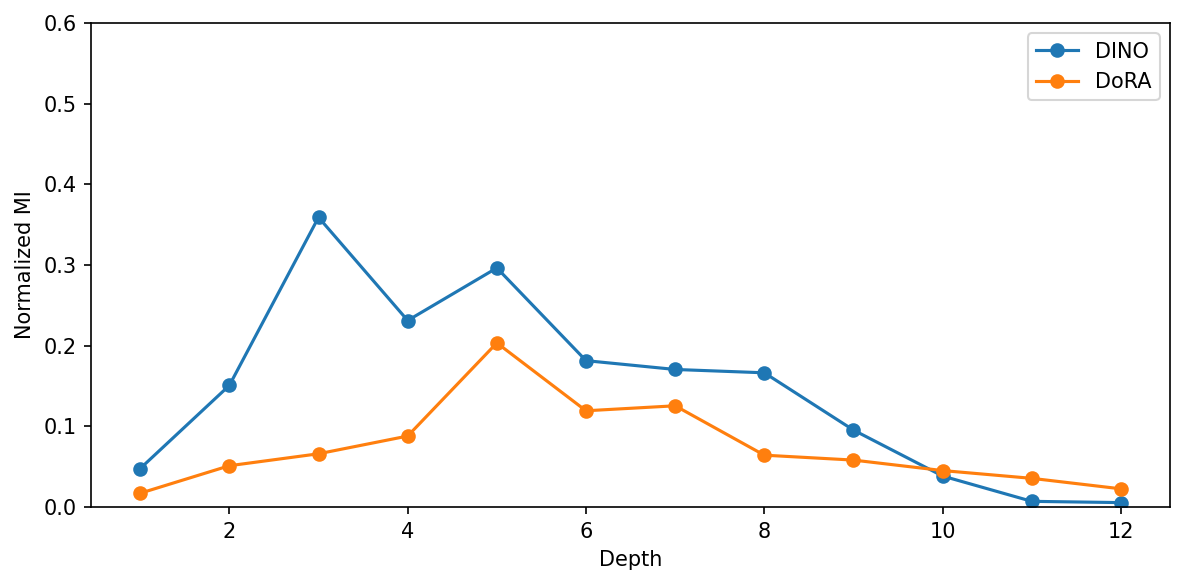

In [9]:
def calculate_nmi_for_model(model, dataset_test, label):
    encoder_length = len(model.blocks)  # 12 for ViT-B
    nmis = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()

        head_name = "clf" if label == "PARTv1_ft" else "head"
        act = ActivationCache(head_name)
        act.hook(model)

        with torch.no_grad():
            _ = model(xs)

        attns = act.get_attns()
        attns = torch.stack(attns)

        def get_res_perfect_square(x):
            return x - int(x**0.5) ** 2

        b = get_res_perfect_square(attns.shape[-2])
        for i, attn in enumerate([attn for attn in attns if attn is not None]):
            attn = attn[:, :, b:, b:]  # drop cls token
            attn = attn + 1e-8
            attn = attn / attn.sum(dim=-1, keepdim=True)  # normalize
            attn = attn.cpu().float()

            nmi = calculate_nmi(attn)
            nmis[i].update(torch.mean(nmi, dim=0))  # average w.r.t. batch

        if idx > -1:
            break

    return [torch.mean(nmi.avg) for nmi in nmis]


models = {
    "DINO": load_dino,
    "DoRA": load_dora,
}


# Create figure with subplots side by side
fig, ax = plt.subplots(1, figsize=(8, 4), dpi=150)

ax.set_xlabel("Depth")
ax.set_ylabel("Normalized MI")

# Plot for each model
for name, loader in models.items():
    model = loader()
    nmis = calculate_nmi_for_model(model, dataset_test, name)
    ax.plot(range(1, 13), nmis, marker="o", label=name)
    ax.set_ylim(top=0.6, bottom=0.0)
    # ax.set_title(name)

ax.legend()
plt.tight_layout()
plt.show()

## Attention Distance


In [10]:
# build off the implementation of https://github.com/sayakpaul/probing-vits


def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def calculate_mean_attention_dist(patch_size, attention_weights):
    """The attention_weights shape = (batch, num_heads, num_patches, num_patches)"""

    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length**2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # now average across all the tokens

    return torch.tensor(mean_distances)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.dino)
INFO:timm.models._hub:[timm/vit_small_patch16_224.dino] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


torch.Size([12, 59, 6, 197, 197])
1


Using cache found in /home/dgcnz/.cache/torch/hub/dgcnz_DoRA_ICLR24_main


Take key teacher in provided checkpoint dict
Pretrained weights found at vit_small_patch16_224.dora.wt_venice.ep100.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
torch.Size([12, 59, 6, 197, 197])
1


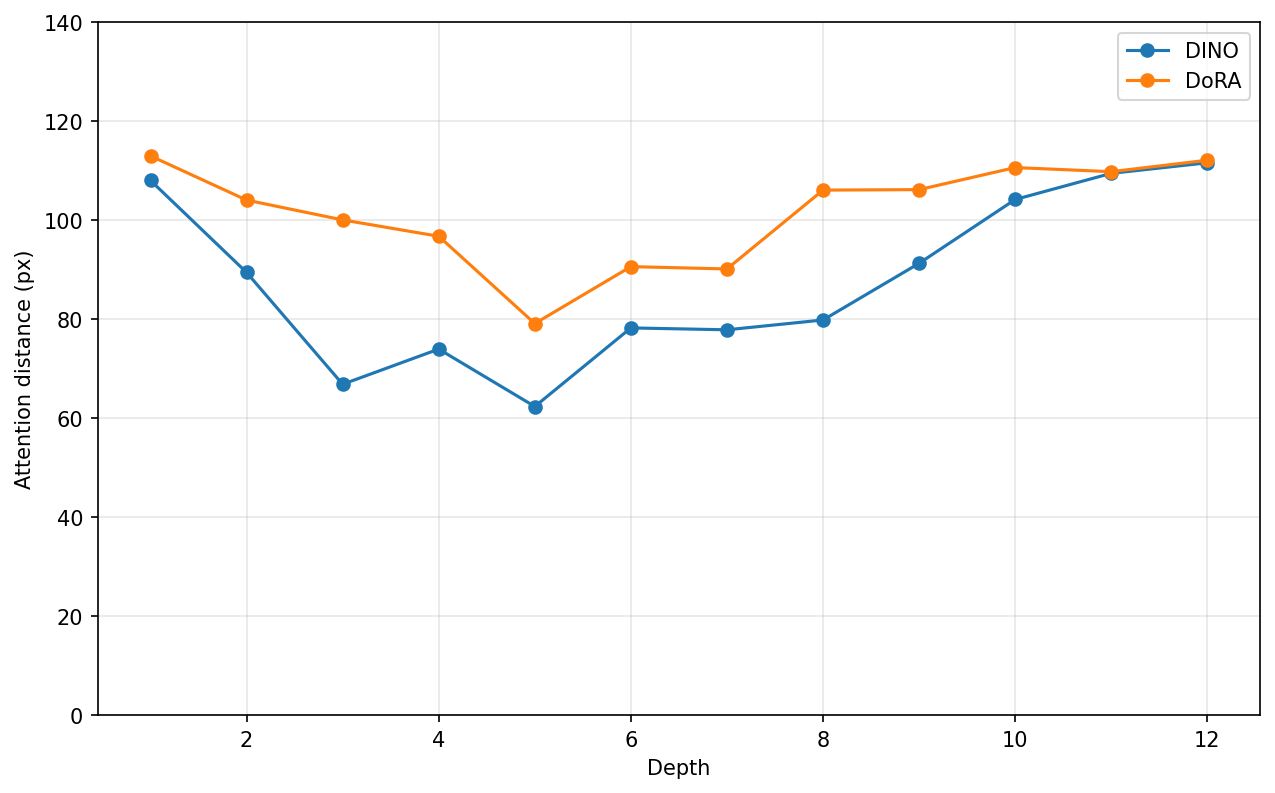

In [11]:
def calculate_distances(model, label: str):
    encoder_length = len(model.blocks)
    distances = [AverageMeter() for _ in range(encoder_length)]

    for idx, (xs, _) in enumerate(dataset_test):
        xs = xs.cuda()
        head_name = "clf" if label == "PARTv1_ft" else "head"
        act = ActivationCache(head_name)
        act.hook(model)
        with torch.no_grad():
            _ = model(xs)

        attns = act.get_attns()
        # stack attns
        attns = torch.stack(attns)
        print(attns.shape)

        # print(act.cache[f"blocks.0.attn.attn_drop"]["input"][0].shape)
        # print(act.cache[f"blocks.0.attn.attn_drop"]["output"].shape)
        def get_res_perfect_square(x):
            # given x = a^2 + b
            # return b
            return x - int(x**0.5) ** 2

        b = get_res_perfect_square(attns.shape[-2])
        print(b)

        for i, attn in enumerate([attn for attn in attns if attn is not None]):
            # remove cls token
            # attn = attn[:,:,1:,1:]
            # remove the first k patches so that the distance matrix is square
            attn = attn[:, :, b:, b:]

            attn = attn + 1e-32
            attn = attn / attn.sum(dim=-1, keepdim=True)
            attn = attn.cpu().float().detach().numpy()

            distance = calculate_mean_attention_dist(
                patch_size=16, attention_weights=attn
            )
            distances[i].update(torch.mean(distance, dim=0))

        if idx > -1:
            break

    return [torch.mean(distance.avg) for distance in distances]


models = {
    "DINO": load_dino,
    "DoRA": load_dora,
}
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=150)
x = range(1, 13)
for label, loader in models.items():
    model = loader()
    # Calculate distances for all models
    distances = calculate_distances(model, label)

    # Plot all curves

    ax.plot(x, distances, label=label, marker="o")

    ax.set_xlabel("Depth")
    ax.set_ylabel("Attention distance (px)")
    ax.set_ylim(top=140, bottom=0)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()